# Implementing VAR Model

***

This code implements the vector autoregression (VAR) model using the `VAR` function from the `statsmodels` module.

Useful documentation can be found [here](https://www.statsmodels.org/dev/vector_ar.html).

One important note is that the data must be stationary to apply a VAR. Either the series themselves are stationary ("VAR in levels") or we take differences to make the data stationary ("VAR in differences"). [Source here.](https://otexts.com/fpp2/VAR.html)

***

## Steps

* **Step 1** Load modules and data.
* **Step 2** Test for stationarity and difference each series if necessary.
* **Step 3** Fit the model.
* **Step 4** Generate and evaluate forecasts.

***

#### Step 1 
Load Modules and Data

In [5]:
# load modules
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.tools.eval_measures as em
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt

In [6]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../../../Data/Train/Clean/full_m3_monthly_micro_clean.csv", delimiter = ',', skip_header = 1)

In [7]:
# select 5 series to model jointly

# forecast horizon
nfs = 2

train, test = ts[5:10,:-nfs], ts[5:10, -nfs:]
num_series, num_periods = train.shape

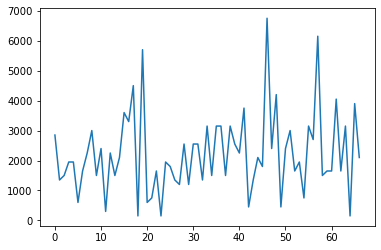

In [8]:
plt.plot(train[0,:])
plt.show()

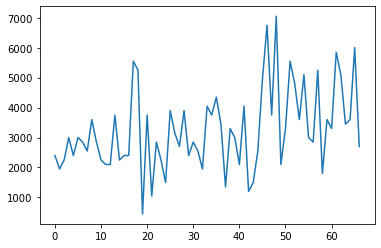

In [9]:
plt.plot(train[1,:])
plt.show()

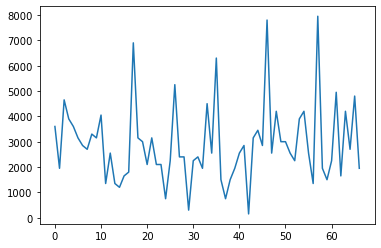

In [10]:
plt.plot(train[2,:])
plt.show()

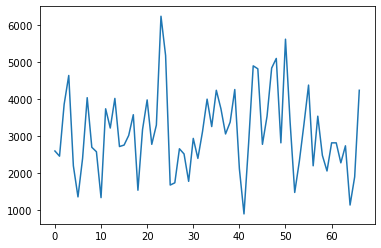

In [11]:
plt.plot(train[3,:])
plt.show()

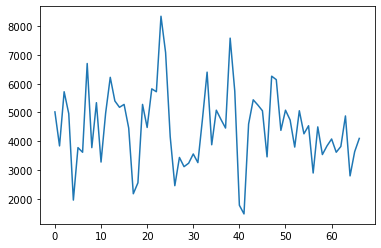

In [12]:
plt.plot(train[4,:])
plt.show()

VAR models should be applied to stationary series, so we will perform differencing to achieve stationarity.

***

#### Step 2 
Test for stationarity and difference each series if necessary.

In [13]:
# array to store differenced training series
diff_train = np.zeros([num_series, num_periods])

In [14]:
# store the number of differences for each series
d_vec = np.zeros([num_series], dtype = int)

# store starting values for reversing later
starting_vals = {}

for i, series in enumerate(train):
    
    starting_vals[i] = [series[0]]
    
    # calculate the number of differences
    d = pm.arima.ndiffs(series, alpha = 0.05, test = 'kpss', max_d = 2)
    
    # store the number of differences for reversing later
    d_vec[i] = d
    
    # store starting values
    if d > 0:
        for j in range(d-1):
            starting_vals[i].append(pm.utils.diff(x = series, differences = j+1)[0])        
    
    # difference the series
    diff_train[i,d:] = pm.utils.diff(x = series, differences = d)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

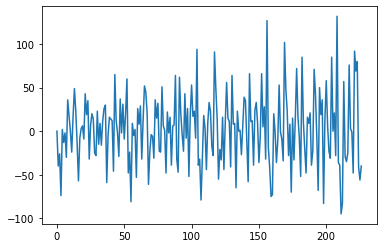

In [11]:
plt.plot(diff_train[0,:])
plt.show()

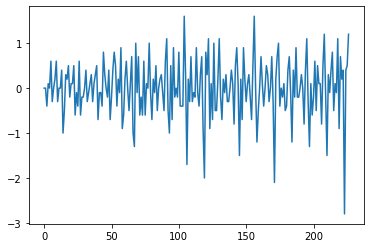

In [12]:
plt.plot(diff_train[1,:])
plt.show()

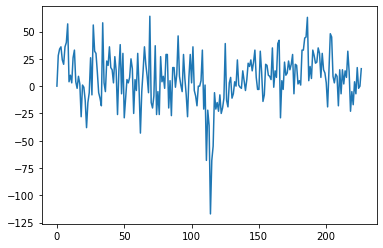

In [13]:
plt.plot(diff_train[2,:])
plt.show()

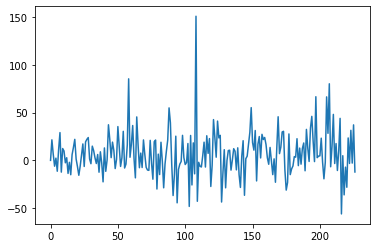

In [14]:
plt.plot(diff_train[3,:])
plt.show()

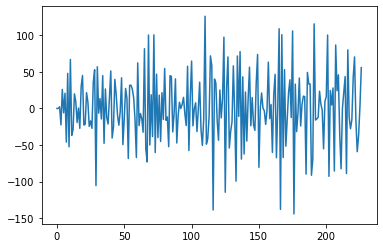

In [15]:
plt.plot(diff_train[4,:])
plt.show()

In [16]:
# find how many periods were differenced out for all series
num_d = 0
for i in range(2):
    if sum(diff_train[:,i]) == 0:
        num_d += 1

In [17]:
diff_train

array([[  0.  , -40.  , -26.  , ..., -41.  , -56.  , -40.  ],
       [  0.  ,   0.  ,  -0.4 , ...,   0.4 ,   0.5 ,   1.2 ],
       [  0.  ,  28.  ,  34.  , ...,  -2.  ,   0.  ,  16.  ],
       [  0.  ,  21.49,   6.44, ...,  -2.86,  37.15, -12.16],
       [  0.  ,   0.  ,   2.3 , ..., -37.26,   2.23,  55.83]])

***

#### Step 3 
Fit the model.

The `VAR` function assumes a $T x K$ multivariate time series.

In [18]:
# transpose data matrix
diff_train = diff_train.T

In [19]:
# instantiate model
var_model = VAR(diff_train)

In [20]:
var_results = var_model.fit(maxlags = 15, ic = 'bic')

In [21]:
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Feb, 2022
Time:                     12:57:45
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    26.4212
Nobs:                     225.000    HQIC:                   25.9231
Log likelihood:          -4419.74    FPE:                1.29443e+11
AIC:                      25.5861    Det(Omega_mle):     1.01960e+11
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.426751         2.819475            0.861           0.389
L1.y1         0.030365         0.068100            0.446           0.656
L1.y2        26.011657         4.267850            6.095           0.000
L1.y3         0.334078

***

#### Step 4 
Generate and evaluate forecasts.

In [22]:
# number of lags in VAR model
lag_order = var_results.k_ar

In [23]:
# forecast nfs steps ahead using lag_order prior values
predictions = var_results.forecast(diff_train[-lag_order:], nfs)

In [24]:
# add predictions to training data and transpose back
full_data = np.concatenate([diff_train, predictions], axis = 0).T
# convert to 'C' order so that diff_inv function will work
full_data = full_data.copy(order = 'C')

In [25]:
# reversing the differencing
for i, series in enumerate(full_data):
    
    for j in range(d_vec[i], 0, -1):
        
        # place the starting value for the series
        series[j-1] = starting_vals[i][j-1]
        
        # reverse one difference
        series = pm.utils.diff_inv(series, differences = 1)[1:]
        
    full_data[i,:] = series

In [26]:
predictions = full_data[:,-nfs:]

In [27]:
# calculate root mean squared error and mean absolute error
# for predictions from all series

# empty arrays for errors
rmse = np.zeros(5)
mae = np.zeros(5)

for i in range(5):
    rmse[i] = em.rmse(test[i,:], predictions[i,:])
    mae[i] = em.meanabs(test[i,:], predictions[i,:])

In [28]:
# average root mean squared error across series
np.mean(rmse)

85.80883651883357

In [29]:
# average mean absolute error across series
np.mean(mae)

67.1471789592313

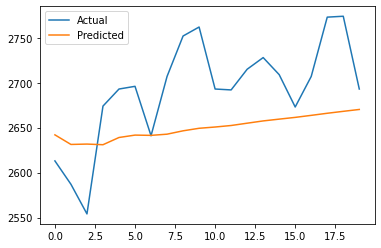

In [30]:
plt.plot(test[0,:], label = "Actual")
plt.plot(predictions[0,:], label = "Predicted")
plt.legend()
plt.show()

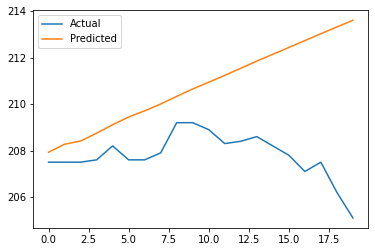

In [31]:
plt.plot(test[1,:], label = "Actual")
plt.plot(predictions[1,:], label = "Predicted")
plt.legend()
plt.show()

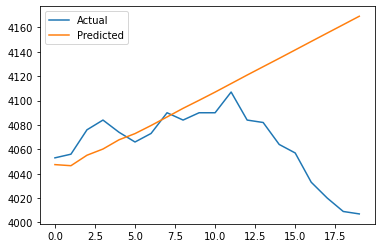

In [32]:
plt.plot(test[2,:], label = "Actual")
plt.plot(predictions[2,:], label = "Predicted")
plt.legend()
plt.show()

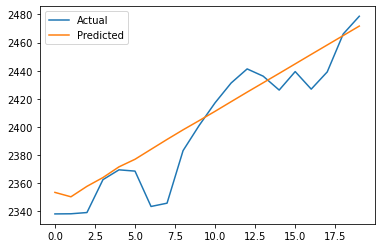

In [33]:
plt.plot(test[3,:], label = "Actual")
plt.plot(predictions[3,:], label = "Predicted")
plt.legend()
plt.show()

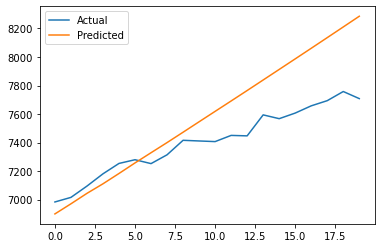

In [34]:
plt.plot(test[4,:], label = "Actual")
plt.plot(predictions[4,:], label = "Predicted")
plt.legend()
plt.show()